### 데이터 불러오기

In [28]:
### Load libraries
import pandas as pd
import selenium
import time
import re
import requests
import urllib.request
import matplotlib.pyplot as plt
from selenium import webdriver
from bs4 import BeautifulSoup
from tqdm import tnrange
from urllib.request import urlopen
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=True)
plt.rcParams.update({
    'font.size': 7,          # 폰트 크기
    'figure.dpi': 150,        # DPI 설정
    'savefig.dpi': 300        # 저장 시 DPI 설정
})

In [29]:
### Load data
train = pd.read_csv('./eda_data.csv', encoding='utf-8')
test = pd.read_csv('./new_data.csv', encoding='utf-8')
print(train.shape, test.shape)

(2026, 2) (922, 9)


### train data 

In [30]:
### 컬럼명 변경
train.columns = ['reviews','keyword2']
train.head()

,reviews,keyword2
0,노포 식당 요즘 인기 있는 곳이래서 왔어요 주꾸미 삼겹살 꽃게 새우 사리 추가해서 ...,친절해요
1,부모님 모시고 감 샐러드 크림파스타 피자 다 너무 잘 드심 친절하고 스테이크도 맛있...,친절해요
2,오버 안 하고 살면서 먹은 닭도리탕 중 가장 맛있었던 것 같아요 풍년 닭도리탕 원래...,친절해요
3,카카오맵 평점이 너무 좋아서 갔는데 역시 맛집이어서 너무 좋았어요 아쟁반으로 해서 ...,친절해요
4,허영만의 백반 기행에도 나온 신촌 고기창고 점심에는 고기도 구워 먹을 수 있고 소고...,친절해요


In [31]:
### 라벨인코딩
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['keyword2'] = le.fit_transform(train['keyword2'])

print(le.classes_)
train['keyword2'].value_counts()

['가성비가 좋아요' '고기 질이 좋아요' '디저트가 맛있어요' '술이 다양해요' '양이 많아요' '음료가 맛있어요'
 '음식이 맛있어요' '인테리어가 멋져요' '재료가 신선해요' '친절해요' '커피가 맛있어요' '특별한 메뉴가 있어요'
 '혼밥하기 좋아요']


0     185
2     184
1     183
10    174
11    172
9     169
3     168
5     153
12    149
8     136
6     136
4     110
7     107
Name: keyword2, dtype: int64

### test data

In [32]:
test.head(1)

,id,title,score_val,category,descript,reviews,keyword1,keyword2,keyword3
0,33752232,황금콩밭,4.36,두부요리,빕구르망 - 합리적인 가격에 훌륭한 음식을 선사하는 친근한 분위기의 레스토랑 미쉐린...,"소쿠리두부도, 코스요리도 먹고싶지만, 오늘은 담백한 14,000원짜리 서리태콩국수 ...",음식이 맛있어요,재료가 신선해요,특별한 메뉴가 있어요


In [33]:
### 필요없는 변수 제거
test = test[['reviews','keyword2']]

### 결측치 제거
print(test.isnull().sum())
test = test.dropna()
print(test.shape)

reviews     26
keyword2    94
dtype: int64
(828, 2)


<AxesSubplot:>

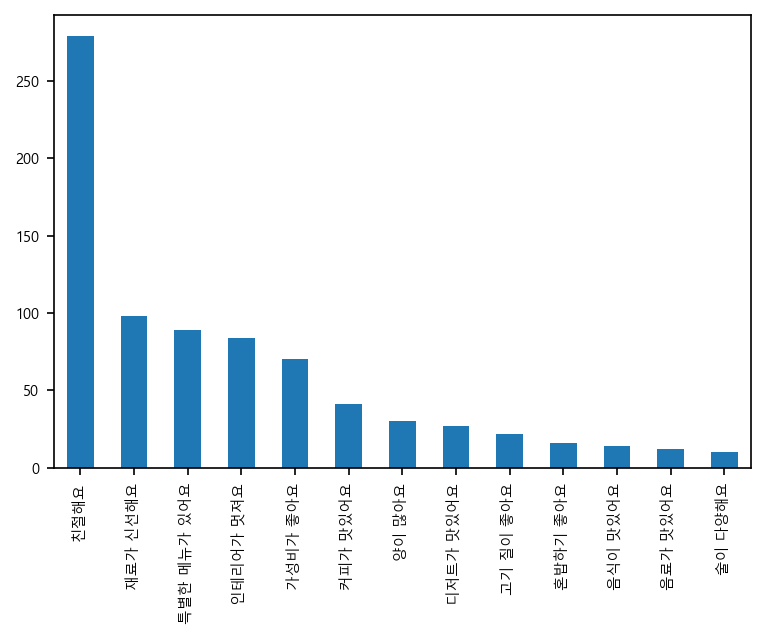

In [37]:
### 학습 데이터에 존재하는 라벨 데이터만 추출
valid_labels = le.classes_
test = test[test['keyword2'].isin(valid_labels)]

### keyword2 확인
test['keyword2'].value_counts().plot.bar()

In [38]:
### 400개의 데이터만 사용
test = test.sample(400, random_state=2024).reset_index(drop=True)
print(test.shape)

### 리뷰 데이터 정제
import re
def clean_review(review):
    # 한글과 공백만 빼고 제거
    review = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)

    # 'ㅋㅋㅋ', 'ㅎㅎㅎ', 'ㅠㅠ', 'ㅜㅜ' 같은 단어들 제거
    review = re.sub(r'ㅋ+','',review)
    review = re.sub(r'ㅎ+','',review)
    review = re.sub(r'ㅠ+','',review)
    review = re.sub(r'ㅜ+','',review)

    # 불필요한 공백 제거
    review = review.strip()
    review = re.sub(r'\s+', ' ', review)
    return review

test['reviews'] = test['reviews'].apply(clean_review)
test['reviews'][0]

(400, 2)


'예전에 방문하고 정말 오랜만에 방문했는데 여전히 맛있었어요 전에 방문했을때 초계국수 너무 맛있게먹어서 그 기억으로 재방문한건데 여전히 초계국수 최고입니다 닭볶음탕과 찰떡궁합이니까 꼭 주문하세요 일요일 저녁 시쯤 방문해서 분 웨이팅 하고 들어왔어요 아슬아슬하게 솔드아웃 면했네요 비 와서 사람 없는 줄 알았는데도 손님이 꽤 있네요 맛은 말할것도 없고 너무 맛있습니다 배불러도 라면사리는 꼭꼭 드세요 닭볶음탕 먹고 싶어서 달려왔어요 마늘 듬뿍 들어간 매콤한 닭볶음탕이고 양도 푸짐한데 가격도 정말 착하네요 반절 정도 먹다가 포장하고 남은 국물에 라면사리 추가해서 먹으니 별미 아이는 닭곰탕 먹었는데 순하고 맛나요 담에 또 먹으러 오고 싶은 맛이네요 시 시작이라 시분에와서 기다렸는데 운좋게 웨이팅이 없어서 번으로 들어갔네요 들어가자마자 음식 바로나오고 친절하게 먹는 방법도 설명해주셨어요 맛은 말할거도 없이 맛있구요 밥 두공기 뚝딱햇어요 집근처에 이런 맛집이 잇으면 좋을거같아요 번창하세요 포방터시장 어머니와아들 골목식당 보면서 너무 맛있어보였는데 실제로 와 보고 싶어서 일어나자마자 한 달음에 왔습니다 기대했던만큼 맛있어요 닭도 어떻게 하신 건지 너무 야들야들하고 양념은 말할 것도 없어용 마늘 많이 들어가서 녹진한 맛 최고에요 많이 맵지 않구요 방송을 빼더라도 충분히 방문해볼만한 집입니당 강추해요 초계국수 국물이 시원하고 맛있었고 닭볶음탕은 마늘이 많이들어가서 맛있어요 마늘 향이 맛을 해치진 않아요 맵기도 적당해서 고학년초등학생은 먹을 수 있을 듯 해요 라면사리도 넣어 먹으니 맛있어요 양념 색상이 엄청 자극적으로 보이는데 짜지 않아서 좋았어요 시간이 지나도 워낙 유명해서 찾아 왔습니다 끓이면 끓일수록 맛이 진해지고 맛있네요 생감자를 좀 익혀서 넣어 주심 좋을듯 십네요끓여서 먹기까지 시간이 좀 오래 걸리네요 재방문 의사 있습니다 웨이팅 할 정도로 맛있어요 닭볶음탕 양도많고 초계국수는 새콤달콤해서 계속 들어가는 맛이더라구요 매장은 좁지만 정이넘치는 곳같아서 좋았습니다 맛있어요 

In [39]:
### 맞춤법 교정
import time
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, InvalidSessionIdException
from time import sleep
from bs4 import BeautifulSoup
import re
import json

options = webdriver.ChromeOptions()
# options.add_argument("--headless")
webdriver_service = Service("C:/Users/lgpc/Downloads/chromedriver.exe")
wd = webdriver.Chrome(service=webdriver_service, options=options)


# 셀레니움 활용 1차 교정
def spell_checking(sentence, text_list):
    for i in tqdm(range(len(sentence))):
        wd.get('http://speller.cs.pusan.ac.kr/')
        wd.implicitly_wait(5)
        try:
            wd.find_element(By.XPATH, '//*[@id="text1"]').send_keys(sentence[i])
            wd.find_element(By.XPATH, '//*[@id="btnCheck"]').click()
            time.sleep(1)
            entity_num = 0
            while True:
                try:
                    wd.find_element(By.XPATH, '//*[@id="tdReplaceWord_'+str(entity_num)+'"]/ul/li/a').click()
                    entity_num += 1
                except:
                    break
            texts = wd.find_element(By.XPATH, '//*[@id="tdCorrection1stBox"]').text
            text_list.append(texts)
        except:
            text_list.append(sentence[i])

spell_list = []
spell_checking(test['reviews'], spell_list)
test['reviews'] = spell_list
test['reviews'][0]

100%|██████████████████████████████████████████████████████████████████████████████| 400/400 [2:47:03<00:00, 25.06s/it]


'예전에 방문하고 정말 오랜만에 방문했는데 여전히 맛있었어요. 전에 방문했을 때 초계국수 너무 맛있게 먹어서 그 기억으로 재방문한 건데 여전히 초계국수 최고입니다. 닭볶음탕과 찰떡궁합이니까 꼭 주문하세요! 일요일 저녁 시쯤 방문해서 분 대기하고 들어왔어요. 아슬아슬하게 매진 면했네요. 비 와서 사람 없는 줄 알았는데도 손님이 꽤 있네요. 맛은 말할 것도 없고 너무 맛있습니다. 배불러도 라면 사리는 꼭꼭 드세요. 닭볶음탕 먹고 싶어서 달려왔어요. 마늘 듬뿍 들어간 매콤한 닭볶음탕이고 양도 푸짐한데 가격도 정말 착하네요. 반절 정도 먹다가 포장하고 남은 국물에 라면 사리 추가해서 먹으니 별미 아이는 닭곰탕 먹었는데 순하고 맛나요. 담에 또 먹으러 오고 싶은 맛이네요. 시 시작이라 신분에 와서 기다렸는데 운 좋게 대기가 없어서 번으로 들어갔네요. 들어가자마자 음식 바로 나오고 친절하게 먹는 방법도 설명해 주셨어요. 맛은 말할 거도 없이 맛있고요 밥 두 공기 뚝딱했어요. 집 근처에 이런 맛집이 있으면 좋을 거 같아요. 번창하세요! 포방터시장 어머니와 아들 골목식당 보면서 너무 맛있어 보였는데 실제로 와 보고 싶어서 일어나자마자 한달음에 왔습니다. 기대했던 만큼 맛있어요. 닭도 어떻게 하신 건지 너무 야들야들하고 양념은 말할 것도 없어요. 마늘 많이 들어가서 녹진한 맛 최고예요 아주 맵지 않고요 방송을 빼더라도 충분히 방문해 볼 만한 집입니다. 강력히 강력히 추천해요 초계국수 국물이 시원하고 맛있었고 닭볶음탕은 마늘이 많이 들어가서 맛있어요. 마늘 향이 맛을 해치진 않아요. 맵기도 적당해서 고학년 초등학생은 먹을 수 있을 듯 하다면 사리도 넣어 먹으니 맛있어요. 양념 색상이 엄청 자극적으로 보이는데 짜지 않아서 좋았어요. 시간이 지나도 워낙 유명해서 찾아왔습니다. 끓이면 끓일수록 맛이 진해지고 맛있네요. 생감자를 좀 익혀서 넣어 주심 좋을 듯싶네요 끓여서 먹기까지 시간이 좀 오래 걸리네요. 재방문 의사 있습니다. 대기 할 정도로 맛있어요. 닭볶음탕 양도 많고 초계국수는

In [40]:
### 문장부호 다시 제거
test['reviews'] = test['reviews'].apply(clean_review)
test['reviews'][0]

'예전에 방문하고 정말 오랜만에 방문했는데 여전히 맛있었어요 전에 방문했을 때 초계국수 너무 맛있게 먹어서 그 기억으로 재방문한 건데 여전히 초계국수 최고입니다 닭볶음탕과 찰떡궁합이니까 꼭 주문하세요 일요일 저녁 시쯤 방문해서 분 대기하고 들어왔어요 아슬아슬하게 매진 면했네요 비 와서 사람 없는 줄 알았는데도 손님이 꽤 있네요 맛은 말할 것도 없고 너무 맛있습니다 배불러도 라면 사리는 꼭꼭 드세요 닭볶음탕 먹고 싶어서 달려왔어요 마늘 듬뿍 들어간 매콤한 닭볶음탕이고 양도 푸짐한데 가격도 정말 착하네요 반절 정도 먹다가 포장하고 남은 국물에 라면 사리 추가해서 먹으니 별미 아이는 닭곰탕 먹었는데 순하고 맛나요 담에 또 먹으러 오고 싶은 맛이네요 시 시작이라 신분에 와서 기다렸는데 운 좋게 대기가 없어서 번으로 들어갔네요 들어가자마자 음식 바로 나오고 친절하게 먹는 방법도 설명해 주셨어요 맛은 말할 거도 없이 맛있고요 밥 두 공기 뚝딱했어요 집 근처에 이런 맛집이 있으면 좋을 거 같아요 번창하세요 포방터시장 어머니와 아들 골목식당 보면서 너무 맛있어 보였는데 실제로 와 보고 싶어서 일어나자마자 한달음에 왔습니다 기대했던 만큼 맛있어요 닭도 어떻게 하신 건지 너무 야들야들하고 양념은 말할 것도 없어요 마늘 많이 들어가서 녹진한 맛 최고예요 아주 맵지 않고요 방송을 빼더라도 충분히 방문해 볼 만한 집입니다 강력히 강력히 추천해요 초계국수 국물이 시원하고 맛있었고 닭볶음탕은 마늘이 많이 들어가서 맛있어요 마늘 향이 맛을 해치진 않아요 맵기도 적당해서 고학년 초등학생은 먹을 수 있을 듯 하다면 사리도 넣어 먹으니 맛있어요 양념 색상이 엄청 자극적으로 보이는데 짜지 않아서 좋았어요 시간이 지나도 워낙 유명해서 찾아왔습니다 끓이면 끓일수록 맛이 진해지고 맛있네요 생감자를 좀 익혀서 넣어 주심 좋을 듯싶네요 끓여서 먹기까지 시간이 좀 오래 걸리네요 재방문 의사 있습니다 대기 할 정도로 맛있어요 닭볶음탕 양도 많고 초계국수는 새콤달콤해서 계속 들어가는 맛이더라고요 매장은 좁지만

In [41]:
### test 데이터 내보내기
test.to_csv('review_test.csv', encoding='utf-8')
test.head()

,reviews,keyword2
0,예전에 방문하고 정말 오랜만에 방문했는데 여전히 맛있었어요 전에 방문했을 때 초계국...,양이 많아요
1,최고의 재료만을 아낌없이 사용하는 디저트 전문점 유희 일본의 명문 제과전문학교에서 ...,특별한 메뉴가 있어요
2,점심 영업을 안 한 이후로 방문은 처음인데 역시는 역시였음 고기 품질이 꽤 좋은 어...,특별한 메뉴가 있어요
3,버섯 보리 리소토 안 드시면 혼나세요 진짜 꼭 드셔야 합니다 보리 알알이 씹히는 식...,특별한 메뉴가 있어요
4,연남동 이색 피자 맛집 대치어 없음 방문했어요 비가 엄청나게 오는 점심이었는데 벌써...,특별한 메뉴가 있어요


<AxesSubplot:>

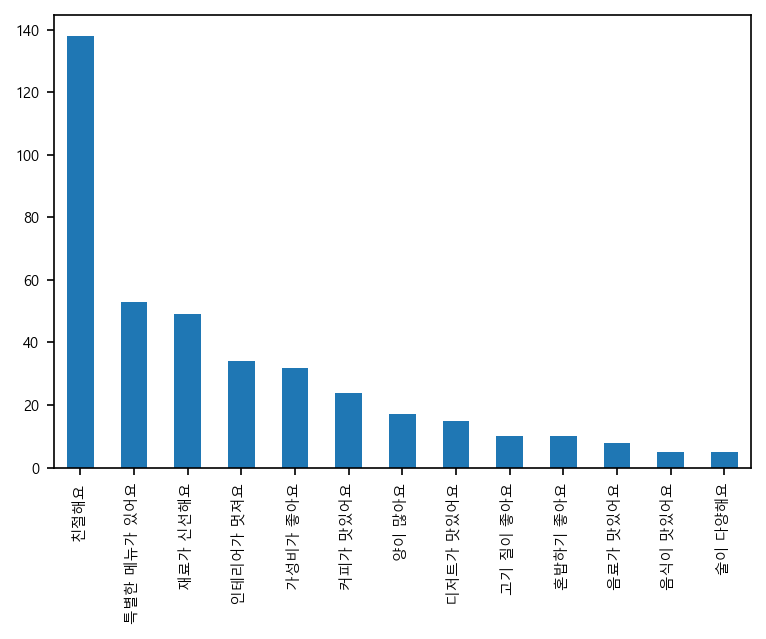

In [109]:
test['keyword2'].value_counts().plot.bar()

### 성능 비교

In [122]:
### 데이터 다시 불러오기
train = pd.read_csv("./review_train.csv", encoding='utf-8')
test = pd.read_csv('./review_test.csv', encoding='utf-8')

<AxesSubplot:>

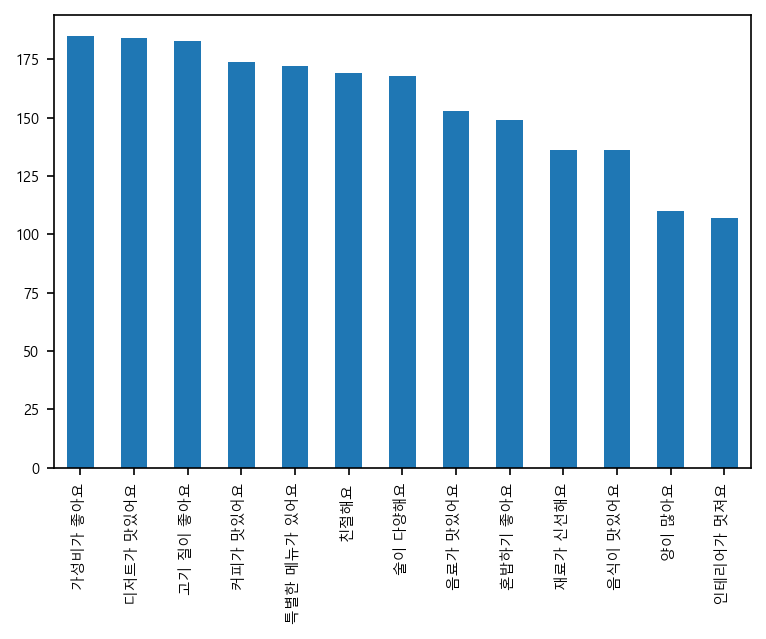

In [123]:
train['keyword2'].value_counts().plot.bar()

<AxesSubplot:>

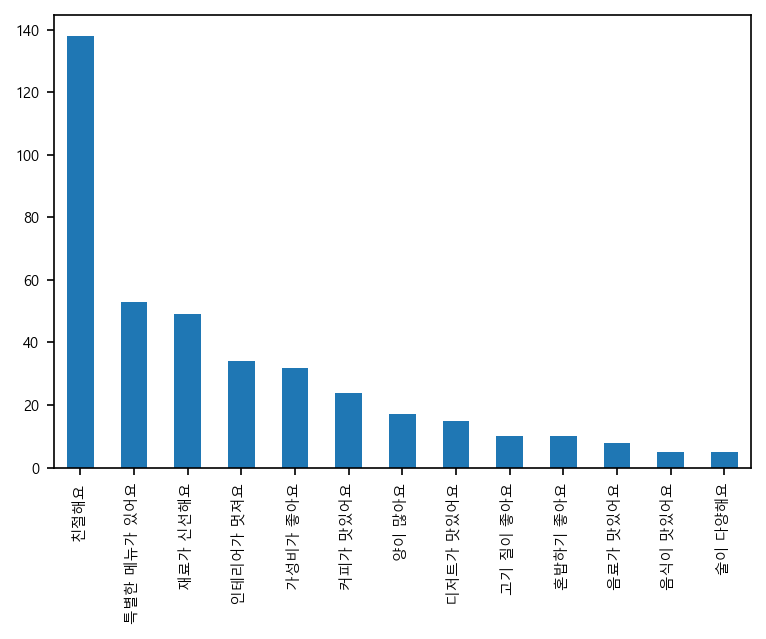

In [124]:
test['keyword2'].value_counts().plot.bar()

In [125]:
### 토큰화
from konlpy.tag import Okt, Hannanum, Kkma, Komoran
import time

# Okt
okt = Okt()
%time train['okt'] = train['reviews'].apply(okt.morphs)
%time test['okt'] = test['reviews'].apply(okt.morphs)

# Hannanum
hannanum = Hannanum()
%time train['hannanum'] = train['reviews'].apply(hannanum.morphs)
%time test['hannanum'] = test['reviews'].apply(hannanum.morphs)

# Komoran
komoran = Komoran()
%time train['komoran'] = train['reviews'].apply(komoran.morphs)
%time test['komoran'] = test['reviews'].apply(komoran.morphs)

CPU times: total: 2min 35s
Wall time: 3min 8s
CPU times: total: 25.6 s
Wall time: 22.9 s
CPU times: total: 2min 31s
Wall time: 3min 8s
CPU times: total: 36.2 s
Wall time: 43.4 s
CPU times: total: 2min 7s
Wall time: 1min 46s
CPU times: total: 25.4 s
Wall time: 22 s


In [126]:
### 불용어 제거
with open('./final_stopwords.txt', 'r', encoding='utf-8') as file:
    stop_words = file.readlines()
stop_words = [word.strip() for word in stop_words]


def remove_stopwords(review):
    return [word for word in review if word not in stop_words]


train['okt'] = [remove_stopwords(review) for review in train['okt']]
test['okt'] = [remove_stopwords(review) for review in test['okt']]

train['hannanum'] = [remove_stopwords(review) for review in train['hannanum']]
test['hannanum'] = [remove_stopwords(review) for review in test['hannanum']]

train['komoran'] = [remove_stopwords(review) for review in train['komoran']]
test['komoran'] = [remove_stopwords(review) for review in test['komoran']]

#### Count Vectorizer

In [127]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train['reviews'])
X_test = vectorizer.transform(test['reviews'])
y_train = train['keyword2']
y_test = test['keyword2']

In [128]:
from sklearn.preprocessing import LabelEncoder
n = len(y_train)
y = pd.concat([y_train, y_test])
le = LabelEncoder()
y = le.fit_transform(y)
y_train = y[:n]
y_test = y[n:]

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
rf = RandomForestClassifier(random_state=2024)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

### test evaluation
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred), columns=col, index=col)
mtx

test 정확도 : 0.2725
test f1 score : 0.2652


,친절해요,커피가 맛있어요,재료가 신선해요,양이 많아요,디저트가 맛있어요,혼밥하기 좋아요,술이 다양해요,고기 질이 좋아요,인테리어가 멋져요,특별한 메뉴가 있어요,가성비가 좋아요,음식이 맛있어요,음료가 맛있어요
친절해요,24,2,1,1,0,1,0,0,0,3,0,0,0
커피가 맛있어요,1,8,0,0,0,0,0,0,0,1,0,0,0
재료가 신선해요,2,0,3,0,0,1,0,1,0,1,6,0,1
양이 많아요,1,0,0,1,0,0,0,0,0,2,0,1,0
디저트가 맛있어요,9,2,0,0,1,0,0,1,0,2,0,0,2
혼밥하기 좋아요,3,0,2,0,0,0,0,0,0,1,1,1,0
술이 다양해요,1,1,0,0,0,0,0,0,0,2,1,0,0
고기 질이 좋아요,4,1,9,1,0,0,0,5,0,7,5,2,0
인테리어가 멋져요,19,1,0,0,0,0,0,2,12,11,0,1,3
특별한 메뉴가 있어요,59,9,3,0,0,1,0,8,7,34,4,9,4


#### TF-IDF

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_okt = TfidfVectorizer(tokenizer=okt.morphs, ngram_range=(1,2), min_df=2, max_df=0.95)
tfidf_okt_matrix = tfidf_okt.fit_transform(train['reviews'])
tfidf_okt_matrix_test = tfidf_okt.transform(test['reviews'])

tfidf_han = TfidfVectorizer(tokenizer=hannanum.morphs, ngram_range=(1,2), min_df=2, max_df=0.95)
tfidf_han_matrix = tfidf_han.fit_transform(train['reviews'])
tfidf_han_matrix_test = tfidf_han.transform(test['reviews'])

tfidf_ko = TfidfVectorizer(tokenizer=komoran.morphs, ngram_range=(1,2), min_df=2, max_df=0.95)
tfidf_ko_matrix = tfidf_ko.fit_transform(train['reviews'])
tfidf_ko_matrix_test = tfidf_ko.transform(test['reviews'])

In [130]:
### X/y split
X_okt_train = tfidf_okt_matrix
X_han_train = tfidf_han_matrix
X_ko_train = tfidf_ko_matrix
y_train = train['keyword2']

X_okt_test = tfidf_okt_matrix_test
X_han_test = tfidf_han_matrix_test
X_ko_test = tfidf_ko_matrix_test
y_test = test['keyword2']

### y label encoding
from sklearn.preprocessing import LabelEncoder
n = len(y_train)
y = pd.concat([y_train, y_test])
le = LabelEncoder()
y = le.fit_transform(y)
y_train = y[:n]
y_test = y[n:]

In [131]:
rf_okt = RandomForestClassifier(random_state=2024)
rf_okt.fit(X_okt_train, y_train)
pred_okt = rf_okt.predict(X_okt_test)

### valid evaluation
acc = accuracy_score(y_test, pred_okt)
f1 = f1_score(y_test, pred_okt, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred_okt), columns=col, index=col)
mtx

test 정확도 : 0.3475
test f1 score : 0.3358


,친절해요,커피가 맛있어요,재료가 신선해요,양이 많아요,디저트가 맛있어요,혼밥하기 좋아요,술이 다양해요,고기 질이 좋아요,인테리어가 멋져요,특별한 메뉴가 있어요,가성비가 좋아요,음식이 맛있어요,음료가 맛있어요
친절해요,24,2,1,1,0,0,0,0,0,2,0,1,1
커피가 맛있어요,1,8,0,0,1,0,0,0,0,0,0,0,0
재료가 신선해요,1,0,7,0,0,0,0,0,0,3,3,1,0
양이 많아요,0,0,0,2,0,0,1,0,0,2,0,0,0
디저트가 맛있어요,3,0,0,0,0,0,0,1,1,6,0,3,3
혼밥하기 좋아요,2,0,1,0,0,2,0,1,0,1,0,1,0
술이 다양해요,2,1,0,0,0,0,0,0,0,0,1,1,0
고기 질이 좋아요,1,1,6,0,0,0,0,7,3,5,7,4,0
인테리어가 멋져요,12,0,0,0,0,0,0,0,9,13,0,7,8
특별한 메뉴가 있어요,49,8,1,0,0,0,0,7,9,47,4,10,3


In [133]:
rf_han = RandomForestClassifier(random_state=2024)
rf_han.fit(X_han_train, y_train)
pred_han = rf_han.predict(X_han_test)

acc = accuracy_score(y_test, pred_han)
f1 = f1_score(y_test, pred_han, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred_han), columns=col, index=col)
mtx

test 정확도 : 0.3100
test f1 score : 0.2928


,친절해요,커피가 맛있어요,재료가 신선해요,양이 많아요,디저트가 맛있어요,혼밥하기 좋아요,술이 다양해요,고기 질이 좋아요,인테리어가 멋져요,특별한 메뉴가 있어요,가성비가 좋아요,음식이 맛있어요,음료가 맛있어요
친절해요,20,2,0,1,0,1,0,0,1,5,0,1,1
커피가 맛있어요,0,8,0,0,0,0,0,0,0,2,0,0,0
재료가 신선해요,1,0,4,0,0,1,0,0,0,1,8,0,0
양이 많아요,1,0,0,2,0,0,0,0,0,1,0,1,0
디저트가 맛있어요,5,1,0,1,0,0,0,1,0,5,0,4,0
혼밥하기 좋아요,1,0,2,0,0,2,0,0,0,2,1,0,0
술이 다양해요,0,1,0,0,0,0,0,1,0,3,0,0,0
고기 질이 좋아요,0,0,9,1,1,0,0,5,1,10,6,1,0
인테리어가 멋져요,14,0,0,0,1,0,0,2,7,11,0,7,7
특별한 메뉴가 있어요,47,13,3,2,1,1,0,8,6,34,3,15,5


In [134]:
rf_ko = RandomForestClassifier(random_state=2024)
rf_ko.fit(X_ko_train, y_train)
pred_ko = rf_ko.predict(X_ko_test)

acc = accuracy_score(y_test, pred_ko)
f1 = f1_score(y_test, pred_ko, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred_ko), columns=col, index=col)
mtx

test 정확도 : 0.3100
test f1 score : 0.2985


,친절해요,커피가 맛있어요,재료가 신선해요,양이 많아요,디저트가 맛있어요,혼밥하기 좋아요,술이 다양해요,고기 질이 좋아요,인테리어가 멋져요,특별한 메뉴가 있어요,가성비가 좋아요,음식이 맛있어요,음료가 맛있어요
친절해요,21,2,0,1,0,0,0,0,0,5,0,1,2
커피가 맛있어요,0,8,0,0,0,0,0,0,0,1,0,1,0
재료가 신선해요,1,0,5,0,0,1,0,0,0,1,6,1,0
양이 많아요,0,0,0,3,0,0,0,0,0,1,0,1,0
디저트가 맛있어요,4,1,0,0,2,0,0,1,1,3,0,4,1
혼밥하기 좋아요,3,0,2,0,0,0,0,1,0,0,2,0,0
술이 다양해요,2,1,1,0,0,0,0,1,0,0,0,0,0
고기 질이 좋아요,0,0,6,0,0,0,0,6,1,8,8,5,0
인테리어가 멋져요,9,1,0,0,0,0,0,1,7,21,0,6,4
특별한 메뉴가 있어요,51,10,3,1,1,0,0,6,5,45,2,12,2


#### Word2Vec

In [135]:
### 하나의 리뷰에 대해 전체 단어의 평균값을 계산하는 함수
def get_features(words, model, num_features):
    feature_vector = np.zeros((num_features),dtype=np.float32)
    num_words = 0

    # 모델 사전에 있는 단어명을 중복없이 ㅓ장
    index2word_set = set(model.wv.index_to_key)

    # 모델 사전에 포함된 단어만 피처로 추가
    for w in words:
        if w in index2word_set:
            num_words += 1
            feature_vector = np.add(feature_vector, model.wv[w])

    # 결과를 단어 수로 나누어 평균 계산
    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)
    return feature_vector

### 전체 리뷰에 대한 평균값을 계산하는 함수
def get_dataset(reviews, model, num_features):
    dataset = list()
    for s in reviews:
        dataset.append(get_features(s, model, num_features))
    reviewFeatureVecs = np.stack(dataset)
    return reviewFeatureVecs

num_features = 300

In [140]:
### Word2Vec - okt
import numpy as np
from gensim.models import Word2Vec
train_okt = train['okt'].tolist()
test_okt = test['okt'].tolist()

# train 데이터로 학습 
word2vec_okt = Word2Vec(sentences=train_okt, vector_size=num_features,
                        window=5, min_count=2, workers=4)
word2vec_okt_train = get_dataset(train_okt, word2vec_okt, num_features)
word2vec_okt_test = get_dataset(test_okt, word2vec_okt, num_features)


### Word2Vec - hannanum
train_han = train['hannanum'].tolist()
test_han = test['hannanum'].tolist()

word2vec_han = Word2Vec(sentences=train_han, vector_size=num_features,
                        window=5, min_count=2, workers=4)
word2vec_han_train = get_dataset(train_han, word2vec_han, num_features)
word2vec_han_test = get_dataset(test_han, word2vec_han, num_features)


### Word2Vec - komoran
train_ko = train['komoran'].tolist()
test_ko = test['komoran'].tolist()

word2vec_ko = Word2Vec(sentences=train_ko, vector_size=num_features,
                        window=5, min_count=2, workers=4)
word2vec_ko_train = get_dataset(train_ko, word2vec_ko, num_features)
word2vec_ko_test = get_dataset(test_ko, word2vec_ko, num_features)

In [141]:
### X/y split
X_okt_train = word2vec_okt_train
X_han_train = word2vec_han_train
X_ko_train = word2vec_ko_train
y_train = train['keyword2']

X_okt_test = word2vec_okt_test
X_han_test = word2vec_han_test
X_ko_test = word2vec_ko_test
y_test = test['keyword2']

### y label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [142]:
rf_okt = RandomForestClassifier(random_state=2024)
rf_okt.fit(X_okt_train, y_train)
pred_okt = rf_okt.predict(X_okt_test)

### valid evaluation
acc = accuracy_score(y_test, pred_okt)
f1 = f1_score(y_test, pred_okt, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred_okt), columns=col, index=col)
mtx

test 정확도 : 0.2450
test f1 score : 0.2429


,친절해요,커피가 맛있어요,재료가 신선해요,양이 많아요,디저트가 맛있어요,혼밥하기 좋아요,술이 다양해요,고기 질이 좋아요,인테리어가 멋져요,특별한 메뉴가 있어요,가성비가 좋아요,음식이 맛있어요,음료가 맛있어요
친절해요,11,2,1,1,5,1,0,2,3,3,1,2,0
커피가 맛있어요,2,6,0,0,1,0,0,0,0,0,0,0,1
재료가 신선해요,0,0,7,0,0,0,0,1,0,0,6,1,0
양이 많아요,0,0,0,1,1,0,0,2,0,0,1,0,0
디저트가 맛있어요,1,3,0,1,1,0,0,0,1,3,0,4,3
혼밥하기 좋아요,0,0,2,0,0,0,2,1,0,0,3,0,0
술이 다양해요,2,0,1,0,1,0,0,0,0,0,1,0,0
고기 질이 좋아요,1,0,6,0,4,2,0,4,3,1,8,5,0
인테리어가 멋져요,6,0,1,0,4,0,1,2,3,9,0,12,11
특별한 메뉴가 있어요,20,9,11,1,9,3,3,6,11,28,5,16,16


In [143]:
rf_han = RandomForestClassifier(random_state=2024)
rf_han.fit(X_han_train, y_train)
pred_han = rf_han.predict(X_han_test)

acc = accuracy_score(y_test, pred_han)
f1 = f1_score(y_test, pred_han, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred_han), columns=col, index=col)
mtx

test 정확도 : 0.2450
test f1 score : 0.2446


,친절해요,커피가 맛있어요,재료가 신선해요,양이 많아요,디저트가 맛있어요,혼밥하기 좋아요,술이 다양해요,고기 질이 좋아요,인테리어가 멋져요,특별한 메뉴가 있어요,가성비가 좋아요,음식이 맛있어요,음료가 맛있어요
친절해요,6,1,0,1,0,4,2,0,1,7,2,2,6
커피가 맛있어요,1,6,0,0,2,0,0,1,0,0,0,0,0
재료가 신선해요,0,0,6,0,0,2,1,1,0,1,3,1,0
양이 많아요,0,0,0,1,0,0,0,2,0,0,0,2,0
디저트가 맛있어요,1,0,0,0,2,0,0,1,2,2,0,5,4
혼밥하기 좋아요,0,0,2,0,0,2,2,0,0,0,2,0,0
술이 다양해요,0,0,0,0,1,0,0,1,0,3,0,0,0
고기 질이 좋아요,0,2,4,0,0,2,0,7,1,2,8,7,1
인테리어가 멋져요,7,1,2,0,4,1,1,3,3,9,0,14,4
특별한 메뉴가 있어요,19,6,8,5,4,0,5,6,14,33,8,24,6


In [144]:
rf_ko = RandomForestClassifier(random_state=2024)
rf_ko.fit(X_ko_train, y_train)
pred_ko = rf_ko.predict(X_ko_test)

acc = accuracy_score(y_test, pred_ko)
f1 = f1_score(y_test, pred_ko, average='weighted')
print(f'test 정확도 : {acc:.4f}')
print(f'test f1 score : {f1:.4f}')

col = list(set(le.inverse_transform(y_test)))
mtx = pd.DataFrame(confusion_matrix(y_test, pred_ko), columns=col, index=col)
mtx

test 정확도 : 0.2775
test f1 score : 0.2732


,친절해요,커피가 맛있어요,재료가 신선해요,양이 많아요,디저트가 맛있어요,혼밥하기 좋아요,술이 다양해요,고기 질이 좋아요,인테리어가 멋져요,특별한 메뉴가 있어요,가성비가 좋아요,음식이 맛있어요,음료가 맛있어요
친절해요,10,1,3,1,0,1,2,1,0,3,2,4,4
커피가 맛있어요,0,7,0,0,1,0,0,0,0,1,0,1,0
재료가 신선해요,0,0,5,0,0,2,1,1,0,0,4,2,0
양이 많아요,0,0,0,1,0,0,0,2,1,0,0,0,1
디저트가 맛있어요,2,0,0,0,1,0,0,0,2,3,0,5,4
혼밥하기 좋아요,0,0,0,0,0,1,2,0,0,0,5,0,0
술이 다양해요,0,0,0,0,0,0,0,0,0,3,1,1,0
고기 질이 좋아요,1,0,6,0,0,2,0,3,2,1,10,8,1
인테리어가 멋져요,8,1,1,0,5,0,0,1,7,14,0,10,2
특별한 메뉴가 있어요,24,6,7,1,4,2,4,6,12,35,8,20,9
